In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from utils.data import process_zones, read_dat, generate_mesh
from train import MeshBaseline
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import pandas as pd
from PIL import Image
rng = np.random.default_rng()

<font size=3>
    
# Inspection 2:
## Flow Field Prediction

## 1. Problem Definition


Formally, the problem is defined as:

> 1. Target: solution of **Reynolds-Average Navier-Stokes Equations**: $u$, where $\frac{D u}{D t}=0$.
> 2. Prediction: $\hat{u}=NN(A, \alpha; \theta)$
> 3. Minimize the error: $\theta=\arg\min L(u, \hat{u})$

$NN(\cdot \ ,\ \cdot \ ;\ \theta)$ is a neural netwrok parameterized by $\theta$.

## 2. Discretization

The **descritazation** of airfoil $A$ and solution $u$ can be in the following three forms:


<font size=3>

### Contour
* The shape is given by points sampled from its contour.
* Basically a vector in $R^n$.
</font>

In [2]:
filename = './data/official/200airfoilKirigingpost/00230_2.5deg.dat'
Z, zones = process_zones(filename)

print(f'Z is of shape{Z.shape}')
x, y = Z[0, 77:440, 0, :2].T
plt.plot(x, y)

Z is of shape(118, 517, 2, 8)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<font size=3>

### Cartesian
* Regularly sampled quantities.
* Similar to images. Can be stored and processed as n-d arrays.
* Lies in $R^{N\times M\times K}$.

<img src="./figures/image_mask.png" width="50%" height="50%">

<font size=3>

### Structured Mesh
* Regular connectivity.
* Obtained through transforms.
* Irregular in physical plane, regular in computational plane.
* Can also be stored as n-d arrays.

The dataset we used in experiment is provided by the Dept. of Aerospace Engineering, SUSTech.

In [3]:
plt.figure(figsize=(10, 8))
for i, zone in enumerate(zones):
    x, y = zone[:, :, 0, :2].reshape(-1, 2).T
    plt.plot(x, y, '.', label=i)

plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<IPython.core.display.Javascript object>


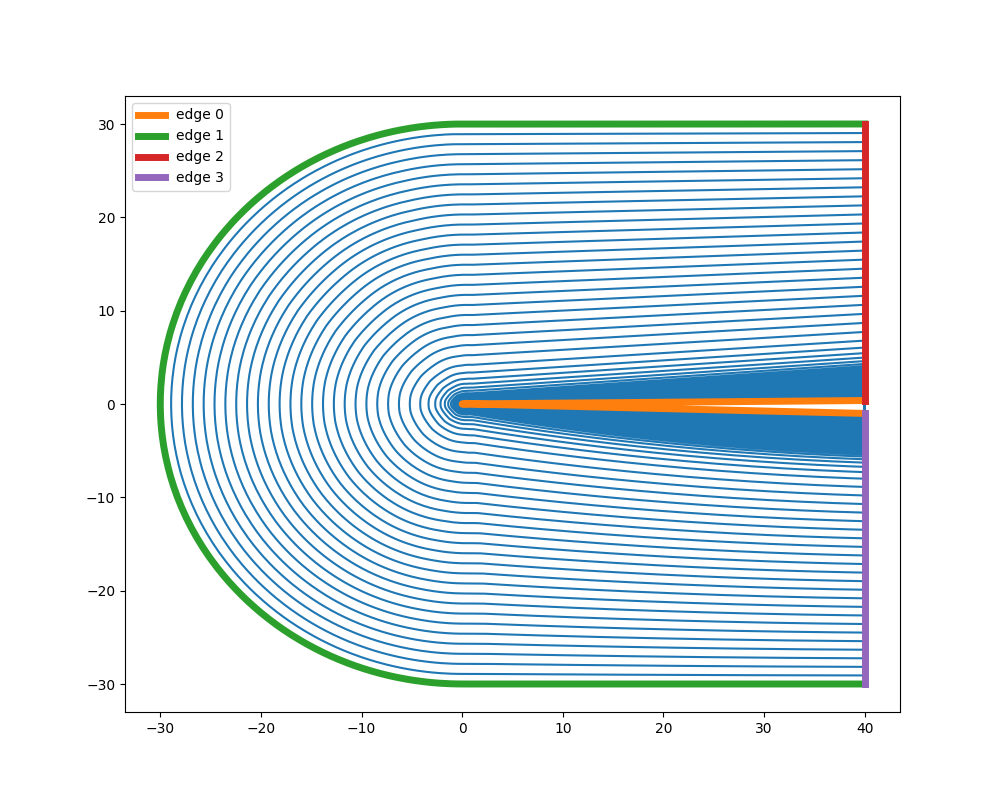

Z is of shape (118, 517, 2, 8).


In [4]:
plt.figure(figsize=(10, 8))
x, y = Z[:, :, 0, :2].reshape(-1, 2).T
plt.plot(x, y)

x, y = Z[0, :, 0, :2].reshape(-1, 2).T
plt.plot(x, y, linewidth=5, label="edge 0")
x, y = Z[-1, :, 0, :2].reshape(-1, 2).T
plt.plot(x, y, linewidth=5, label="edge 1")
x, y = Z[:, 0, 0, :2].reshape(-1, 2).T
plt.plot(x, y, linewidth=5, label="edge 2")
x, y = Z[:, -1, 0, :2].reshape(-1, 2).T
plt.plot(x, y, linewidth=5, label="edge 3")
plt.legend()
print(f'Z is of shape {Z.shape}.')

<font size=3>

### Unstructured Mesh
* Irregular connectivity.
* $G=\{V, \ E\}$

In [5]:
contour = read_dat('./report/ag03.dat')
generate_mesh(contour, './report/mesh.su2', visualize=True)

<font size=3>

## 3. Experiments
### 1. Cartesian (Image-to-Image Translation)
> Architecture
> ![title](./report/network_1.png)

<IPython.core.display.Javascript object>


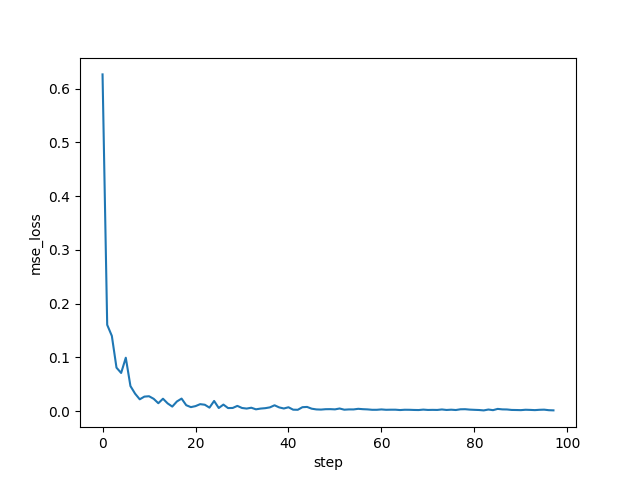

In [6]:
training_curve = pd.read_csv('./report/image-training_loss.csv')
loss = training_curve['Value'].to_numpy()
plt.figure()
plt.plot(np.arange(len(loss)), loss)
plt.xlabel('step')
plt.ylabel('mse_loss')
plt.show()

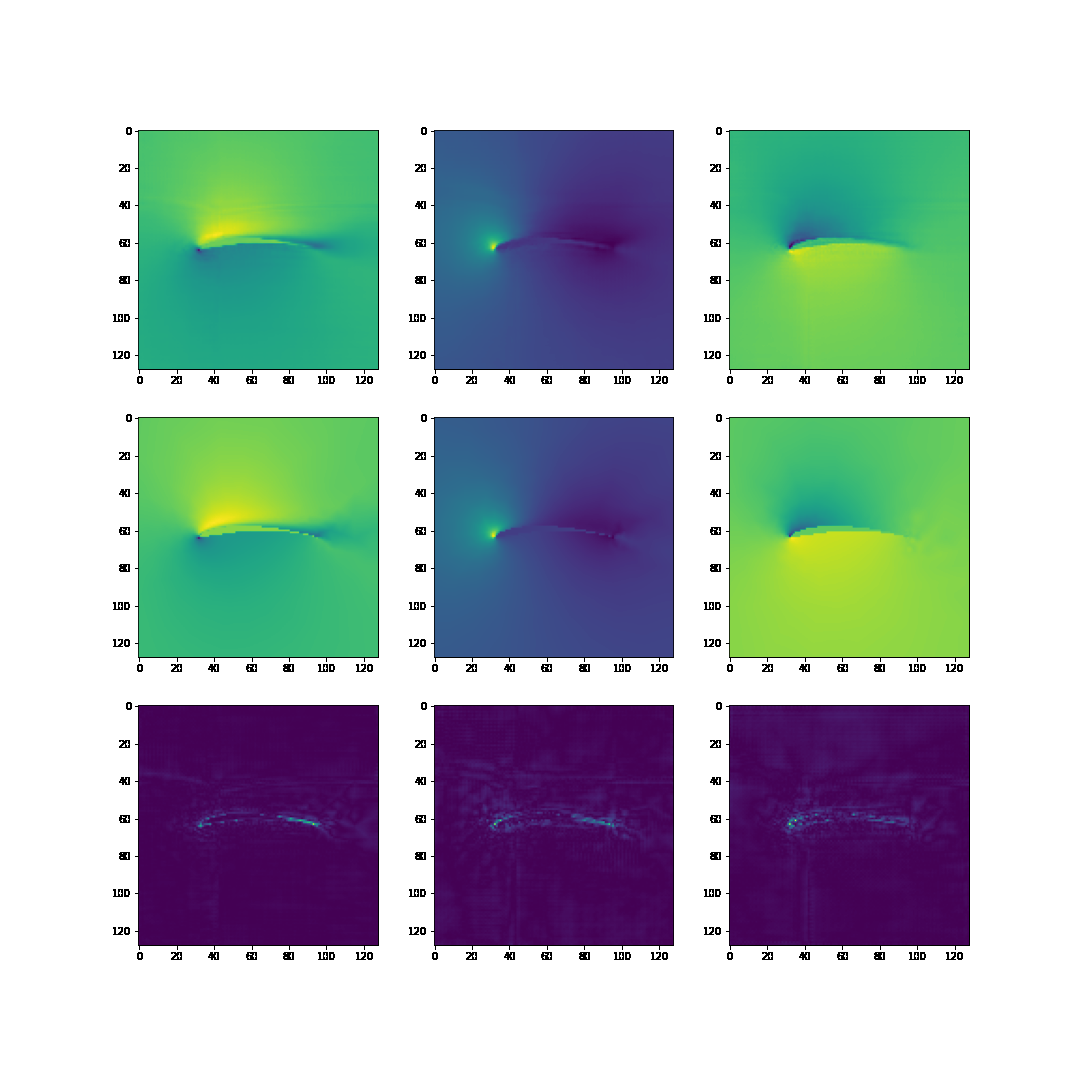

In [7]:
Image.open('./figures/result_3.png')

<font size=3>

### 2. Structured Mesh

> Overall Architecture: 
> ![title](./report/network.png)

In [8]:
model = MeshBaseline()
print(model)
print(f'total #parameters: {model.model_size} MB')

MeshBaseline(
  (encoder_geo): CNNEncoder(
    (conv): Sequential(
      (0): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
      (1): PReLU(num_parameters=1)
    )
    (downsample): Sequential(
      (0): Downsample(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): PReLU(num_parameters=32)
      )
      (1): Downsample(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): PReLU(num_parameters=64)
      )
      (2): Downsample(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): PReLU(num_parameters=128)
      )
      (3): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): PReLU(num_parameters=128)
      )
    )
    (output): Sequential(
      (0): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (encoder_param): MLPEnc

<font size=3>

> ### Conditional Normalization  
> **Instance Normalization** and its variants are commonly used in tasks where the output is an image, such as iamge generation and style transfer.
$$
IN(x)=\gamma(\frac{x-\mu(x)}{\sigma(x)})+\beta\\
AdaIN(x, y)=\gamma(y)(\frac{x-\mu(x)}{\sigma(x)})+\beta(y)
$$
where $y$ is another image that has the style we want to transfer $x$ to.
<img src="https://img-blog.csdnimg.cn/2019061217185282.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl8zNTU3Njg4MQ==,size_16,color_FFFFFF,t_70" width="70%" height="70%">

> In our case,
$$
CIN(x, \mathbf{c})=\gamma(\mathbf{c})(\frac{x-\mu(x)}{\sigma(x)})+\beta(\mathbf{c})
$$
where $\gamma(\mathbf{c})$ and $\beta(\mathbf{c})$ are given by the MLP encoder $E_c$.
    
> ### Upsampling
> **PixelShuffle** is a techniques commonly used in modern super-resolution networks.
<img src="https://paperswithcode.com/media/methods/pixelshuffle_Ed27NA5.pbm" width="%30" height="%30">

<IPython.core.display.Javascript object>


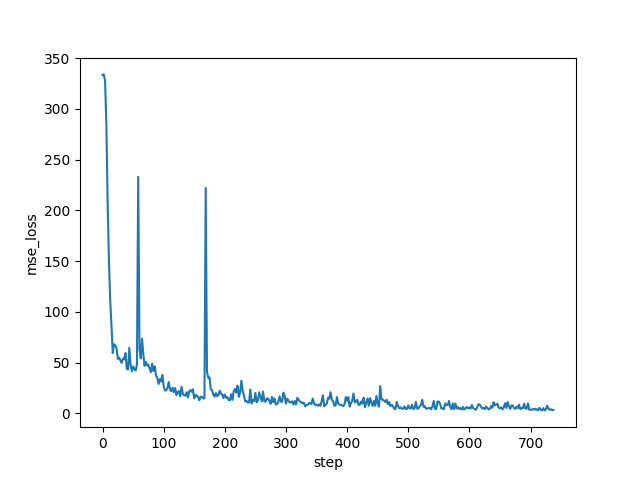

In [9]:
training_curve = pd.read_csv('./report/mesh-baseline-training_loss.csv')
loss = training_curve['Value'].to_numpy()[5:360]
plt.figure()
plt.plot(np.arange(len(loss))*50/24, loss)
plt.xlabel('step')
plt.ylabel('mse_loss')
plt.show()

<IPython.core.display.Javascript object>


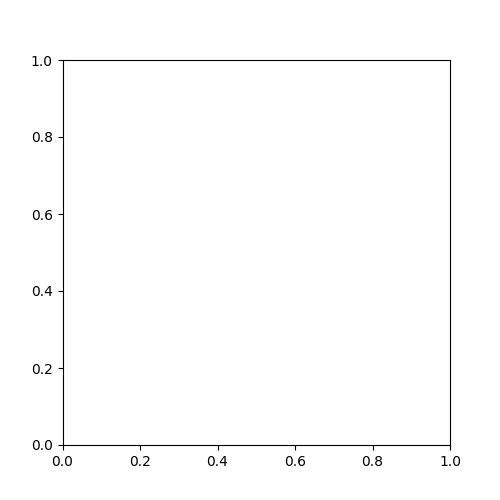

In [10]:
e = list(range(0,100,10)) + list(range(99, 1599, 100))
def func(frame):
    result = Image.open(f'./figures/{frame}.png')
    ax.imshow(result)
    plt.title(f'Epoch {frame}')
fig, ax = plt.subplots(figsize=(5, 5))
ani = anim.FuncAnimation(fig, func, e, interval=200)
plt.show()

<font size=3>

## 4. Limitations
1. Normalization

Normalizations are critical in various ways:
* Impose Regularization.
* Stablize training by giving better gradients.
* Enable acctivvations.
* ...  

But in this task they may not be directly applicable. The distributions (in value) of the physical quantities sampled are shown below:
<img src="./report/distribution.png" width="60%" height="60%">

2. Limitation of Convolutional Layers
3. Generalization Issue

<font size=3>

Normalizations based on first-order statistcs (mean and variance) are all of the form:
$$
Normalization(x)=\gamma(\frac{x-\mu(x)}{\sigma(x)})+\beta
$$
and the difference is just along which dimension the statistics are computed.

<IPython.core.display.Javascript object>


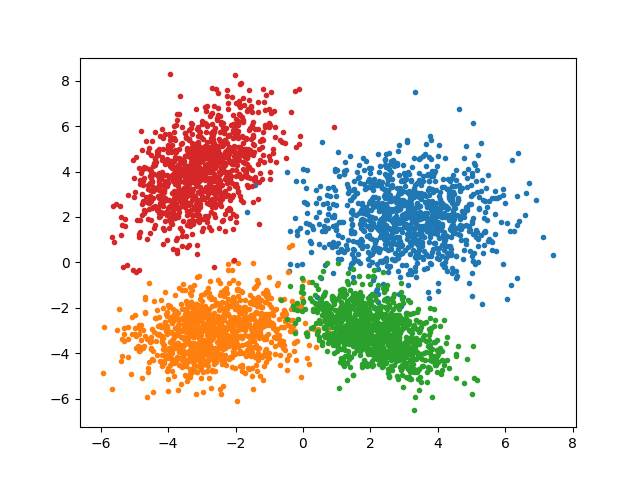

torch.Size([4, 2, 32, 32])


In [11]:
# Normalization problem
n = 1024
a = rng.multivariate_normal(mean=[3, 2], cov=[[2, 0], [0, 2]], size=n).T
b = rng.multivariate_normal(mean=[-2.5, -3], cov=[[1.5, 0.2], [0.2, 1]], size=n).T
c = rng.multivariate_normal(mean=[2, -3], cov=[[1, -0.5], [-0.5, 1]], size=n).T
d = rng.multivariate_normal(mean=[-3, 4], cov=[[1, 0.6], [0.6, 2]], size=n).T

plt.figure()
plt.plot(a[0], a[1], '.')
plt.plot(b[0], b[1], '.')
plt.plot(c[0], c[1], '.')
plt.plot(d[0], d[1], '.')

t = torch.tensor(np.stack((a, b, c, d)), dtype=torch.float).reshape(-1, 2, 32, 32)
print(t.shape)

<IPython.core.display.Javascript object>


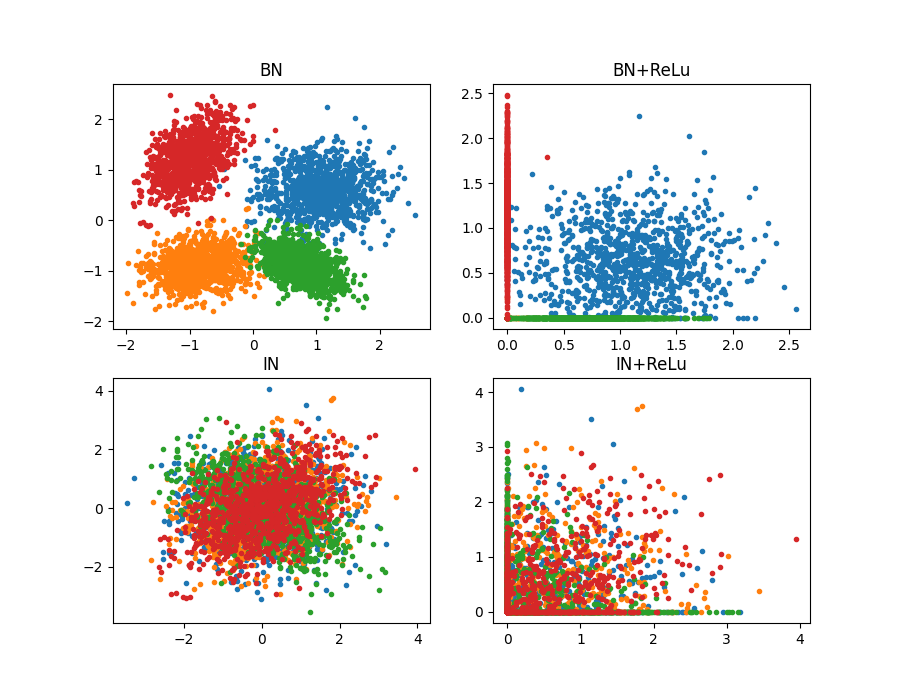

In [12]:
BN = nn.BatchNorm2d(2)
IN = nn.InstanceNorm2d(2)

fig, axes = plt.subplots(2, 2, figsize=(9, 7))

with torch.no_grad():
    out = BN(t).reshape(4, 2, -1)
    for _ in out: axes[0, 0].plot(_[0], _[1], '.')
    axes[0, 0].set_title('BN')
    out = F.relu(out)
    for _ in out: axes[0, 1].plot(_[0], _[1], '.')
    axes[0, 1].set_title('BN+ReLu')
    out = IN(t).reshape(4, 2, -1)
    for _ in out: axes[1, 0].plot(_[0], _[1], '.')
    axes[1, 0].set_title('IN')
    out = F.relu(out)
    for _ in out: axes[1, 1].plot(_[0], _[1], '.')
    axes[1, 1].set_title('IN+ReLu')
plt.show()

In [4]:
z = Z[20:40, 250:275, 0, :2]
fig, ax = plt.subplots()
x, y = z.reshape(-1, 2).T
ax.plot(x, y, '.')
frames = [(i, j) for j in range(z.shape[1]-2) for i in range(z.shape[0]-2)]
x, y = z[:3,:3].reshape(-1, 2).T
kernel, = ax.plot(x, y, 'o')
def func(frame):
    i, j = frame
    x, y = z[i:i+3, j:j+3].reshape(-1, 2).T
    kernel.set_data(x, y)
ani = anim.FuncAnimation(fig, func, frames, interval=500)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<font size=3>

## 5. Miscellaneous
1. **Lattice Boltzmann** Fluid Solver in Taichi
$$
\text{A system can be described with a distribution } f(\mathbf{x},\mathbf{u},t) \\
\frac{\partial f}{\partial t} + \mathbf{u}\cdot\nabla\mathbf{f}=\mathbf{\Omega}=\omega(f_{eq}-f)
$$
2. A Dynamical System View of Neural Newtworks
3. Coordinate-based Networks

In [18]:
%run ./report/LBM.py --rey=1000 --steps=20

[Taichi] Starting on arch=cuda
[Taichi] materializing...
#####################################################
Reynolds number = 1000.0, inner time steps = 20
#####################################################


<font size=3>

* **Theory**: 50%
 1. Computational Fluid Dynamics
 2. Deep Learning
    * Architecture
    * Learning Process & Behavior 

    
* **Experiments**: 50%
 1. Processing data: 30%
 2. Implementing models: 20%
 3. Tuning: 30%
 4. Empirical verifications and exploring: 20%